## Imports

In [1]:
import dgl
import numpy as np
import pandas as pd
import networkx as nx
import random
import itertools

from helper_functions import build_map_1

Using backend: pytorch


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

## Creating the graph:

In [3]:
# CONSTANTS

n_states = 34

In [4]:
G = dgl.DGLGraph()
G.add_nodes(n_states)
u, v = build_map_1()
G = dgl.graph((u, v))

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [5]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(G)

34
128
Graph(num_nodes=34, num_edges=128,
      ndata_schemes={}
      edata_schemes={})


In [6]:
from node2vec import Node2Vec

KeyboardInterrupt: 

In [ ]:
node2vec = Node2Vec(G.to_networkx(), dimensions=34, walk_length=10, num_walks=200, workers=6)

In [ ]:
model = node2vec.fit(window=4)

In [14]:
import matplotlib.pyplot as plt
#plt.scatter(model.wv.vectors[:, 0], model.wv.vectors[:, 1], c=y_true)

In [15]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [16]:
colors = [[.4,.5,.9] for _ in range(G.number_of_nodes())]

In [17]:
#for i in train_ind:
#    colors[i] = [.9, .3, .3]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


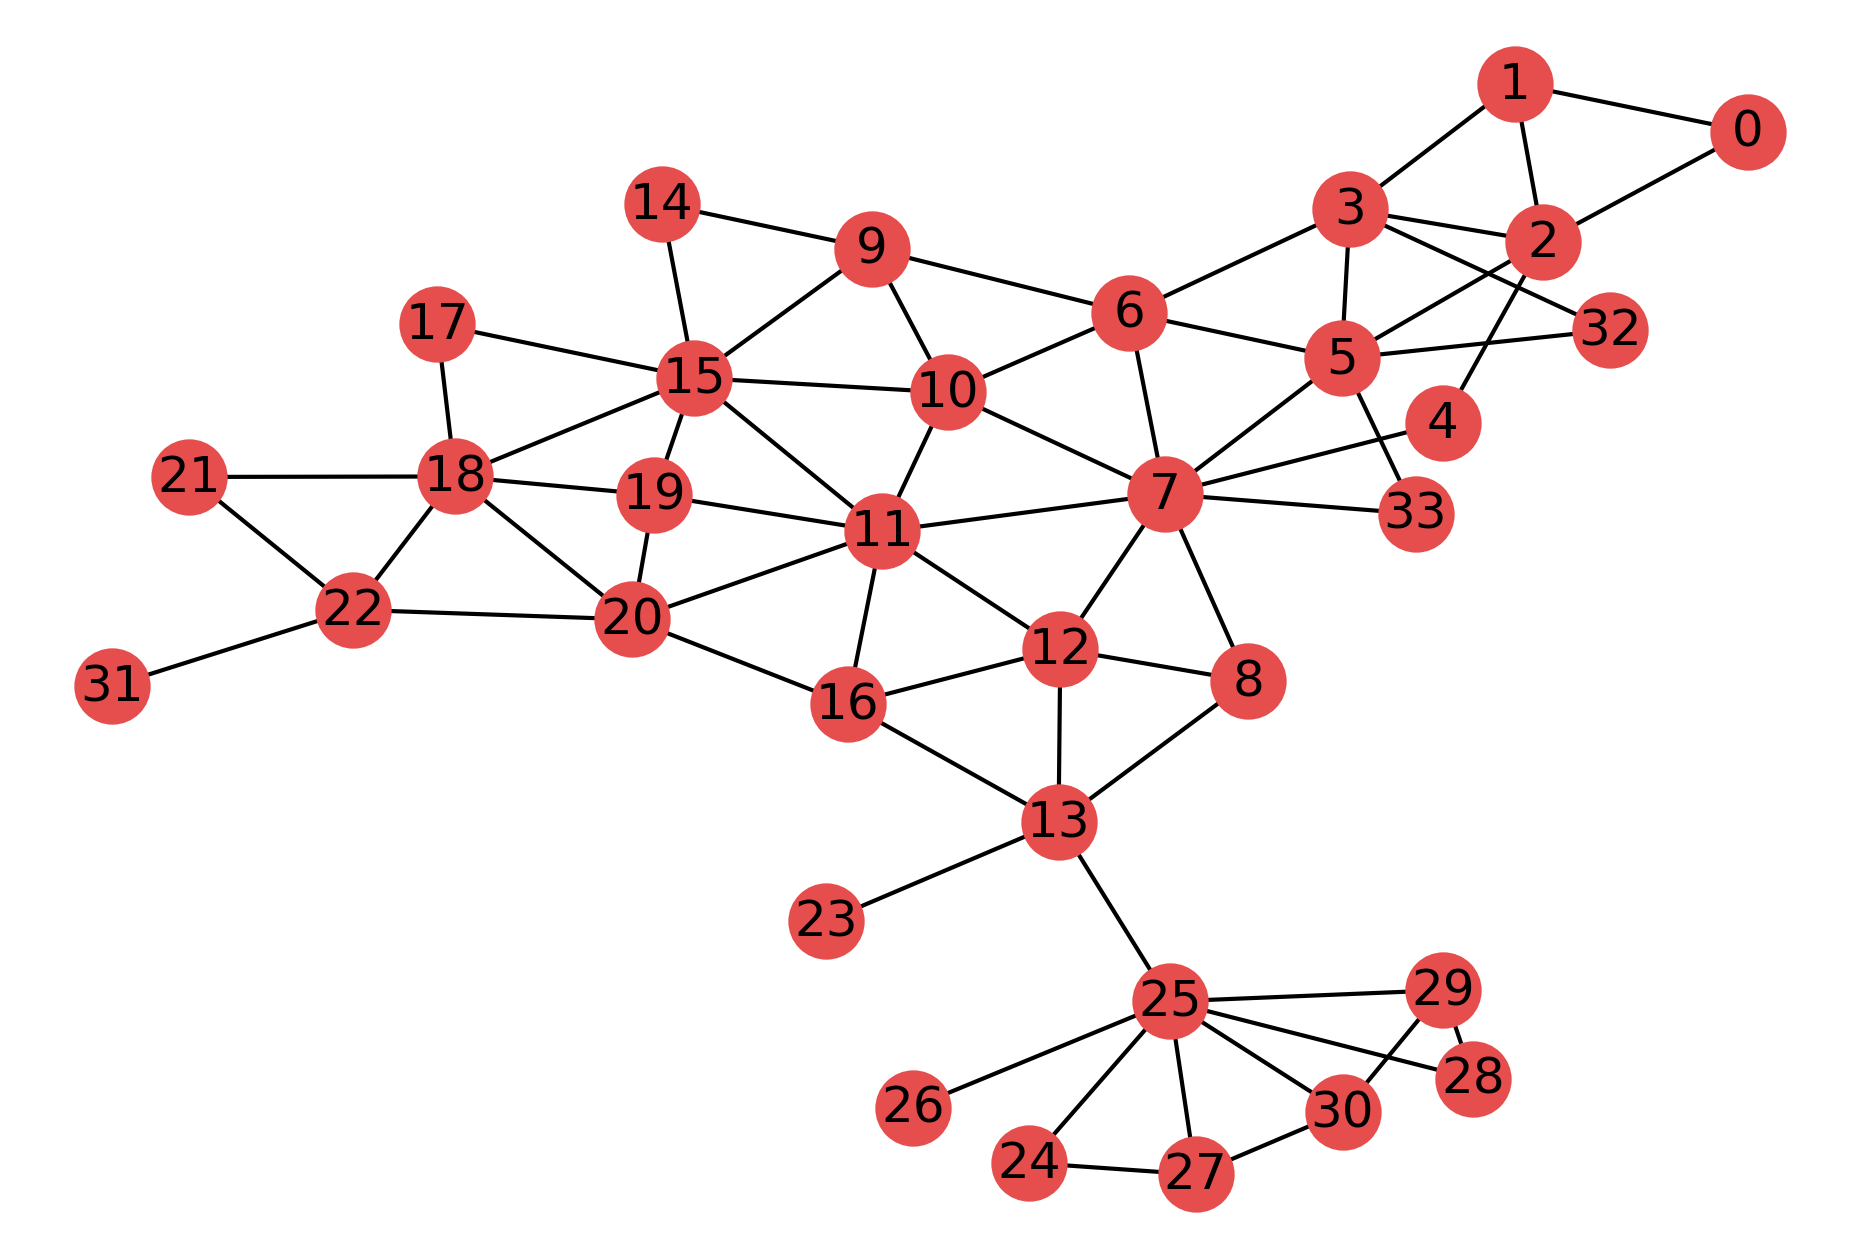

In [18]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[.9, .3, .3])
plt.show()

In [19]:
import json
cases = json.load(open("./data/alldata.json", "r"))

In [20]:
states_ = open('./data/state_code_mapping.txt', 'r').read()

In [21]:
name_map_dict = dict([[s.rsplit(" ", 1)[0], s.rsplit(" ", 1)[1]] for s in states_.split('\n')])

## Loading and pre-processing the data:

In [22]:
cases.keys()

dict_keys(['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DL', 'DN', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'LD', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN', 'TR', 'TT', 'UN', 'UP', 'UT', 'WB'])

In [23]:
# manually found this online since data wasn't present in the file
cases['LA']['dates']['2020-06-12']['total']['confirmed'] = 239

In [24]:
with open('./data/states_list.txt', 'r') as file:
    states = file.readlines()

for ind in range(len(states) - 1):
    states[ind] = states[ind][:-1]

In [25]:
df = pd.read_csv("./data/state_data.csv")
df.head(5)

,Rank,State or union territory,Population,National Share (%),Decadal growth(2001–2012),Rural population,Percent rural,Urban population,Percent urban,Area[16],Density[a],Sex ratio,Foreign Visits,Health Index
0,1,Uttar Pradesh,"199,812,341",16.51,20.2%,"155,317,278",77.73,"44,495,063",22.27,"240,928 km2 (93,023 sq mi)",828.0,912,4745181,29.16
1,2,Maharashtra,"112,374,333",9.28,20.0%,"61,556,074",54.78,"50,818,259",45.22,"307,713 km2 (118,809 sq mi)",365.0,929,5528704,64.53
2,3,Bihar,"104,099,452",8.60,25.4%,"92,341,436",88.71,"11,758,016",11.29,"94,163 km2 (36,357 sq mi)",1102.0,918,1093141,32.42
3,4,West Bengal,"91,276,115",7.54,13.8%,"62,183,113",68.13,"29,093,002",31.87,"88,752 km2 (34,267 sq mi)",1029.0,953,1656145,58.25
4,5,Madhya Pradesh,"72,626,809",6.00,16.3%,"52,557,404",72.37,"20,069,405",27.63,"308,245 km2 (119,014 sq mi)",236.0,931,327958,38.69


In [26]:
# used average 7.9 for ladakh and for telangana took 2015 value of 8.03, averaged dadra and daman and diu
# https://www.censusindia.gov.in/vital_statistics/SRS_Report_2015/6.Chap%202-Population%20Composition-2015.pdf
senior_arr = [9.7, 9.9, 7.4, 8.5, 7.9, 10.4, 7.5, 7.7, 7.9, 9.8, 9.5, 8.5, 12.6, 7.1, 6.7, 10.3, 7.8, 8.7, 6.8, 7.4, 8.9, 10.2, 7.9, 4.7, 7.0, 5.2, 11.2, 4.6, 9.7, 6.3, 6.4, 6.7, 4.35, 8.03]

In [27]:
sum(senior_arr)/len(senior_arr), len(senior_arr)

(8.037647058823529, 34)

In [28]:
df['Senior Citizen Share'] = senior_arr

In [29]:
actual_data = pd.read_csv("./data/actual_covid_data_17april.csv")
actual_data = actual_data.drop([0, 37]).reset_index(drop=True)
actual_data = actual_data.drop([32, 35]).reset_index(drop=True)
actual_data.iloc[5, 0] = 'NCT of Delhi'

In [30]:
# replacing with data right before the 1st wave (12th June 2020)

case_data = actual_data[['State', 'Confirmed']]
for state in case_data['State']:
    code = name_map_dict[state]
    case_data[case_data['State'] == state]['Confirmed'] = cases[code]['dates']['2020-06-12']['total']['confirmed']

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
case_data['label'] = 0

label_1 = case_data['Confirmed'].quantile(q=1/3)
label_2 = case_data['Confirmed'].quantile(q=2/3)

case_data.iloc[case_data.index[case_data['Confirmed'] >= label_1], 2] = 1
case_data.iloc[case_data.index[case_data['Confirmed'] >= label_2], 2] = 2

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [32]:
y_true = []
for state in states:
    y_true.append(case_data[case_data['State'] == state]['label'].values[0])
y_true = np.array(y_true)

In [33]:
train_ind = [32, 27, 16, 3, 15, 20]
train_labels = [0, 0, 1, 1, 2, 2]

train_ind = [5, 14, 21, 19, 11, 23] 
train_labels = [1, 0, 2, 1, 2, 0]

test_ind = []
for i in range(n_states):
    if i not in train_ind:
        test_ind.append(i)

## Encoding the features:

In [34]:
for i in train_ind:
    print(y_true[i], states[i], df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0])

1 Haryana 48046
0 Dadra and Nagar Haveli and Daman and Diu 7369
2 Kerala 1189771
1 Telangana 323326
2 Chhattisgarh 6817
0 Sikkim 133388


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [36]:
acc_dict = {
    "svc": [],
    "knn": [],
    "rf" : [],
    "gcn": []
}

In [37]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size)
        self.lin = torch.nn.Linear(hidden_size, 3)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.leaky_relu(h)
        h = self.conv2(g, h)
        h = F.leaky_relu(h)
        h = self.lin(h)
        return h

In [40]:
#embed = nn.Embedding(n_states, n_feats)  
#inputs = embed.weight
#labeled_nodes = torch.tensor([32, 27, 3, 4, 15, 20])  
#labels = torch.tensor([0, 0, 1, 1, 2, 2])  
test_acc = 0
train_acc = 0
while train_acc != 1 or test_acc < 0.8000:
    while True:
        train_ind = random.sample([0, 1, 2, 3, 4, 5, 32, 33, 7], k=1) + random.sample([6, 9, 14, 15, 10], k=1) \
                             + random.sample([17, 18, 19, 20, 21, 22, 31], k=2) + random.sample([8, 11, 12, 13, 16], k=1) \
                             + random.sample([23, 24, 25, 26, 27, 28, 29, 30], k=1) 
        train_labels = [y_true[i] for i in train_ind]
        tl = np.array(train_labels)
        if tl[tl == 0].shape[0] == 2 \
        and tl[tl == 1].shape[0] == 2 \
        and tl[tl == 2].shape[0] == 2:
            break

    test_ind = []
    for i in range(n_states):
        if i not in train_ind:
            test_ind.append(i)

    n_feats = 2
    feats = torch.zeros(n_states, n_feats)
    for i in range(n_states):

        density = df[df['State or union territory'] == states[i]]['Density[a]'].values[0]
        percent_urban = df[df['State or union territory'] == states[i]]['Percent urban'].values[0]
        health_index = df[df['State or union territory'] == states[i]]['Health Index'].values[0]
        foreign_visits = df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0]
        percent_rural = df[df['State or union territory'] == states[i]]['Percent rural'].values[0]
        share = df[df['State or union territory'] == states[i]]['National Share (%)'].values[0]
        senior_citizen = df[df['State or union territory'] == states[i]]['Senior Citizen Share'].values[0]

        # adding the features we want: 
        feats[i] = (torch.Tensor([foreign_visits, density]))

    feats = (feats - feats[train_ind, :].mean(axis=0)) / feats[train_ind, :].std(axis=0)
            
    labeled_nodes = torch.tensor(train_ind)  
    labels = torch.tensor(train_labels) 

    epochs = 200
    net = GCN(n_feats, 16, 3)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    all_logits = []

    for epoch in range(epochs + 1):
        logits = net(G, feats)
        all_logits.append(logits.detach())
        logp = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(logp[labeled_nodes], labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc = (np.array(y_true)[train_ind] == all_logits[-1].argmax(axis=1).numpy()[train_ind]).mean()
        test_acc = (np.array(y_true)[test_ind] == all_logits[-1].argmax(axis=1).numpy()[test_ind]).mean()

        if epoch % 20 == 0:
            #print(f'Epoch: {epoch}\nLoss: {round(loss.item(), 4)} Test Accuracy: {round(acc, 4)} Train Acc: {round(acc2, 4)}')
            print("Epoch: %3d Train Loss: %.4f Train Acc: %.4f Val Acc: %.4f" % (epoch, round(loss.item(), 4), round(train_acc, 4), round(test_acc, 4)))
        if round(train_acc, 4) == 1:
            break

Epoch:   0 Train Loss: 1.0968 Train Acc: 0.3333 Val Acc: 0.2857
Epoch:  20 Train Loss: 0.6055 Train Acc: 0.6667 Val Acc: 0.6071
Epoch:   0 Train Loss: 1.1072 Train Acc: 0.3333 Val Acc: 0.3214
Epoch:  20 Train Loss: 0.6672 Train Acc: 0.8333 Val Acc: 0.6429
Epoch:  40 Train Loss: 0.2806 Train Acc: 0.8333 Val Acc: 0.5714
Epoch:   0 Train Loss: 1.1207 Train Acc: 0.3333 Val Acc: 0.3929
Epoch:  20 Train Loss: 0.5693 Train Acc: 0.8333 Val Acc: 0.6429
Epoch:   0 Train Loss: 1.0547 Train Acc: 0.1667 Val Acc: 0.1071
Epoch:  20 Train Loss: 0.5879 Train Acc: 0.5000 Val Acc: 0.3214
Epoch:   0 Train Loss: 1.0888 Train Acc: 0.3333 Val Acc: 0.2500
Epoch:  20 Train Loss: 0.7345 Train Acc: 0.5000 Val Acc: 0.6429
Epoch:  40 Train Loss: 0.4643 Train Acc: 0.8333 Val Acc: 0.7857
Epoch:  60 Train Loss: 0.3496 Train Acc: 0.8333 Val Acc: 0.7500
Epoch:  80 Train Loss: 0.2541 Train Acc: 0.8333 Val Acc: 0.7500
Epoch:   0 Train Loss: 1.1691 Train Acc: 0.3333 Val Acc: 0.3571
Epoch:   0 Train Loss: 1.1171 Train Acc:

KeyboardInterrupt: 

In [52]:
acc_dict = {
    "svc": [],
    "knn": [],
    "rf" : [],
    "gcn": []
}

In [53]:
for _ in range(100):
    while True:
        train_ind = random.sample([0, 1, 2, 3, 4, 5, 32, 33, 7], k=1) \
                    + random.sample([6, 9, 14, 15, 10], k=1) \
                    + random.sample([17, 18, 19, 20, 21, 22, 31], k=2) \
                    + random.sample([8, 11, 12, 13, 16], k=1) \
                    + random.sample([23, 24, 25, 26, 27, 28, 29, 30], k=1) 
        train_labels = [y_true[i] for i in train_ind]
        tl = np.array(train_labels)
        if tl[tl == 0].shape[0] == 2 and tl[tl == 1].shape[0] == 2 and tl[tl == 2].shape[0] == 2:
            break

    print(train_ind, train_labels)
    test_ind = []
    for i in range(n_states):
        if i not in train_ind:
            test_ind.append(i)

    n_feats = 2
    feats = torch.zeros(n_states, n_feats)
    for i in range(n_states):
        density = df[df['State or union territory'] == states[i]]['Density[a]'].values[0]
        foreign_visits = df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0]
        feats[i] = (torch.Tensor([foreign_visits, density]))

    feats = (feats - feats[train_ind, :].mean(axis=0)) / feats[train_ind, :].std(axis=0)

    our_data = feats[train_ind, :]
    clf = RandomForestClassifier(n_estimators=32)
    clf.fit(our_data, train_labels)
    acc = (clf.predict(feats) == y_true).mean()
    print(acc)
    acc_dict['rf'].append(acc)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(our_data, train_labels)
    acc = (clf.predict(feats) == y_true).mean()
    print(acc)
    acc_dict['knn'].append(acc)     

    clf = SVC()
    clf.fit(our_data, train_labels)
    acc = (clf.predict(feats) == y_true).mean()
    print(acc)
    acc_dict['svc'].append(acc)

    labeled_nodes = torch.tensor(train_ind)  
    labels = torch.tensor(train_labels) 

    epochs = 200
    net = GCN(n_feats, 12, 3)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    all_logits = []

    for epoch in range(epochs + 1):
        logits = net(G, feats)
        all_logits.append(logits.detach())
        logp = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(logp[labeled_nodes], labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc = (np.array(y_true)[train_ind] == all_logits[-1].argmax(axis=1).numpy()[train_ind]).mean()
        test_acc = (np.array(y_true)[test_ind] == all_logits[-1].argmax(axis=1).numpy()[test_ind]).mean()
        
        if epoch % 20 == 0:
            print("Epoch: %3d Train Loss: %.4f Train Acc: %.4f Val Acc: %.4f" % (epoch, round(loss.item(), 4), round(train_acc, 4), round(test_acc, 4)))
        
        if round(train_acc, 4) == 1:
            break

    test_acc = (np.array(y_true) == all_logits[-1].argmax(axis=1).numpy()).mean()
    print(test_acc)
    acc_dict['gcn'].append(test_acc)

[5, 9, 31, 21, 12, 29] [1, 2, 0, 2, 1, 0]
0.7058823529411765
0.29411764705882354
0.4411764705882353
Epoch:   0 Train Loss: 1.0694 Train Acc: 0.5000 Val Acc: 0.5000
Epoch:  20 Train Loss: 0.6078 Train Acc: 1.0000 Val Acc: 0.5714
0.6470588235294118
[4, 9, 20, 31, 16, 28] [1, 2, 2, 0, 1, 0]
0.5
0.47058823529411764
0.35294117647058826
Epoch:   0 Train Loss: 1.2297 Train Acc: 0.5000 Val Acc: 0.5000
Epoch:  20 Train Loss: 0.7588 Train Acc: 0.5000 Val Acc: 0.6071
Epoch:  40 Train Loss: 0.5766 Train Acc: 0.6667 Val Acc: 0.7143
Epoch:  60 Train Loss: 0.4366 Train Acc: 0.8333 Val Acc: 0.7143
Epoch:  80 Train Loss: 0.2622 Train Acc: 0.8333 Val Acc: 0.7143
0.7647058823529411
[3, 14, 21, 20, 12, 23] [1, 0, 2, 2, 1, 0]
0.6764705882352942
0.3235294117647059
0.5588235294117647
Epoch:   0 Train Loss: 1.0927 Train Acc: 0.3333 Val Acc: 0.3571
Epoch:  20 Train Loss: 0.5542 Train Acc: 0.8333 Val Acc: 0.7143
0.7352941176470589
[5, 14, 22, 19, 13, 27] [1, 0, 2, 1, 2, 0]
0.6764705882352942
0.29411764705882354

0.5
0.29411764705882354
0.5588235294117647
Epoch:   0 Train Loss: 1.1040 Train Acc: 0.5000 Val Acc: 0.3571
Epoch:  20 Train Loss: 0.6921 Train Acc: 0.8333 Val Acc: 0.6071
0.7058823529411765
[32, 6, 21, 19, 8, 23] [0, 2, 2, 1, 1, 0]
0.7058823529411765
0.4117647058823529
0.5294117647058824
Epoch:   0 Train Loss: 1.1276 Train Acc: 0.3333 Val Acc: 0.3571
Epoch:  20 Train Loss: 0.8711 Train Acc: 0.6667 Val Acc: 0.7857
Epoch:  40 Train Loss: 0.5113 Train Acc: 0.6667 Val Acc: 0.7143
0.7352941176470589
[0, 10, 22, 19, 8, 30] [0, 2, 2, 1, 1, 0]
0.5294117647058824
0.29411764705882354
0.5
Epoch:   0 Train Loss: 1.1844 Train Acc: 0.1667 Val Acc: 0.1429
Epoch:  20 Train Loss: 0.6645 Train Acc: 0.6667 Val Acc: 0.5000
Epoch:  40 Train Loss: 0.3825 Train Acc: 0.8333 Val Acc: 0.7143
Epoch:  60 Train Loss: 0.2566 Train Acc: 0.8333 Val Acc: 0.7143
0.7647058823529411
[0, 6, 18, 19, 12, 27] [0, 2, 2, 1, 1, 0]
0.6470588235294118
0.35294117647058826
0.5882352941176471
Epoch:   0 Train Loss: 1.2295 Train Acc:

0.6470588235294118
0.38235294117647056
0.38235294117647056
Epoch:   0 Train Loss: 1.1451 Train Acc: 0.3333 Val Acc: 0.3214
Epoch:  20 Train Loss: 0.7322 Train Acc: 0.6667 Val Acc: 0.6071
0.8529411764705882
[33, 10, 17, 31, 8, 27] [2, 2, 1, 0, 1, 0]
0.6470588235294118
0.3235294117647059
0.47058823529411764
Epoch:   0 Train Loss: 1.1207 Train Acc: 0.3333 Val Acc: 0.3571
Epoch:  20 Train Loss: 0.7732 Train Acc: 0.8333 Val Acc: 0.5714
Epoch:  40 Train Loss: 0.3445 Train Acc: 0.8333 Val Acc: 0.6786
0.7352941176470589
[2, 14, 18, 19, 13, 28] [1, 0, 2, 1, 2, 0]
0.4411764705882353
0.38235294117647056
0.47058823529411764
Epoch:   0 Train Loss: 1.1051 Train Acc: 0.3333 Val Acc: 0.2857
Epoch:  20 Train Loss: 0.6368 Train Acc: 0.6667 Val Acc: 0.6786
Epoch:  40 Train Loss: 0.3512 Train Acc: 0.8333 Val Acc: 0.6786
0.7058823529411765
[0, 15, 20, 19, 8, 23] [0, 2, 2, 1, 1, 0]
0.5588235294117647
0.29411764705882354
0.5294117647058824
Epoch:   0 Train Loss: 1.1184 Train Acc: 0.1667 Val Acc: 0.3571
Epoch

0.7352941176470589
[3, 14, 17, 20, 13, 24] [1, 0, 1, 2, 2, 0]
0.5882352941176471
0.35294117647058826
0.47058823529411764
Epoch:   0 Train Loss: 1.1038 Train Acc: 0.1667 Val Acc: 0.3571
Epoch:  20 Train Loss: 0.6530 Train Acc: 0.6667 Val Acc: 0.6429
Epoch:  40 Train Loss: 0.3591 Train Acc: 0.8333 Val Acc: 0.7500
0.7647058823529411
[1, 9, 22, 31, 12, 27] [1, 2, 2, 0, 1, 0]
0.7058823529411765
0.2647058823529412
0.47058823529411764
Epoch:   0 Train Loss: 1.1174 Train Acc: 0.0000 Val Acc: 0.2500
Epoch:  20 Train Loss: 0.7297 Train Acc: 0.6667 Val Acc: 0.7500
Epoch:  40 Train Loss: 0.3136 Train Acc: 0.8333 Val Acc: 0.6071
0.6176470588235294
[5, 6, 31, 17, 11, 24] [1, 2, 0, 1, 2, 0]
0.5
0.35294117647058826
0.4411764705882353
Epoch:   0 Train Loss: 1.1353 Train Acc: 0.1667 Val Acc: 0.3214
Epoch:  20 Train Loss: 0.7956 Train Acc: 0.6667 Val Acc: 0.4286
Epoch:  40 Train Loss: 0.4720 Train Acc: 0.8333 Val Acc: 0.6071
0.7058823529411765
[2, 14, 18, 22, 8, 23] [1, 0, 2, 2, 1, 0]
0.6176470588235294


In [54]:
for mod in acc_dict:
    print(mod, max(acc_dict[mod]), sum(acc_dict[mod]) / len(acc_dict[mod]))

svc 0.6764705882352942 0.47882352941176437
knn 0.5 0.33999999999999986
rf 0.7647058823529411 0.5908823529411766
gcn 0.8529411764705882 0.6770588235294119


In [57]:
len(acc_dict['gcn'])

100

In [62]:
acc_dict

{'svc': [0.4411764705882353,
  0.35294117647058826,
  0.5588235294117647,
  0.6764705882352942,
  0.5588235294117647,
  0.5294117647058824,
  0.47058823529411764,
  0.47058823529411764,
  0.4411764705882353,
  0.47058823529411764,
  0.5882352941176471,
  0.4117647058823529,
  0.5,
  0.5588235294117647,
  0.38235294117647056,
  0.47058823529411764,
  0.5,
  0.5,
  0.47058823529411764,
  0.5294117647058824,
  0.6176470588235294,
  0.5588235294117647,
  0.38235294117647056,
  0.47058823529411764,
  0.5588235294117647,
  0.5588235294117647,
  0.6176470588235294,
  0.4411764705882353,
  0.6470588235294118,
  0.47058823529411764,
  0.5588235294117647,
  0.5294117647058824,
  0.5,
  0.5882352941176471,
  0.38235294117647056,
  0.47058823529411764,
  0.47058823529411764,
  0.4117647058823529,
  0.4411764705882353,
  0.47058823529411764,
  0.47058823529411764,
  0.5294117647058824,
  0.29411764705882354,
  0.47058823529411764,
  0.2647058823529412,
  0.5588235294117647,
  0.6470588235294118,
  

## Results:

In [63]:
op_df = pd.DataFrame(all_logits[-1][:].numpy())
op_list = []

for i in range(n_states):
    op_list.append((all_logits[-1][i].numpy().argmax()))

op_df['preds'] = pd.Series(op_list)
op_df['State'] = states

In [64]:
final_df = pd.merge(op_df, case_data, on='State')#.sort_values('label', ascending=False)[['State', 'preds', 'label']]
(final_df['preds'] == final_df['label']).mean()

0.7647058823529411

In [65]:
final_df

,0,1,2,preds,State,Confirmed,label
0,0.175401,0.189357,-0.097930,1,Ladakh,11709,0
1,0.254180,0.249244,-0.191417,0,Jammu and Kashmir,145166,1
2,-3.214385,2.096022,2.045867,1,Himachal Pradesh,75587,1
3,-2.180093,1.551304,1.346453,1,Punjab,290707,1
4,0.102723,0.230097,-0.002535,1,Uttarakhand,121403,1
5,-2.842018,1.883259,1.749768,1,Haryana,342077,1
6,-4.505276,2.568283,3.294712,2,Rajasthan,404355,2
7,-9.038009,5.013725,5.918803,2,Uttar Pradesh,821054,2
8,-1.199922,0.912139,0.846226,1,Bihar,307557,1
9,-6.010197,3.504621,3.643728,2,Gujarat,384688,2


In [67]:
final_df['preds'].value_counts()

2    14
1    10
0    10
Name: preds, dtype: int64

In [68]:
final_df['label'].value_counts()

2    12
1    11
0    11
Name: label, dtype: int64

In [69]:
final_df[final_df['preds'] != final_df['label']]

,0,1,2,preds,State,Confirmed,label
0,0.175401,0.189357,-0.097930,1,Ladakh,11709,0
1,0.254180,0.249244,-0.191417,0,Jammu and Kashmir,145166,1
13,-3.931998,2.446497,2.372046,1,West Bengal,651508,2
14,-1.649797,1.170480,0.955994,1,Dadra and Nagar Haveli and Daman and Diu,4568,0
17,-3.497541,2.125215,2.140234,2,Goa,66261,1
19,-5.524448,3.226292,3.362906,2,Telangana,346331,1
25,0.469566,0.240934,-0.390382,0,Assam,222940,1
32,-1.289900,0.831759,1.278235,2,Chandigarh,32878,0


In [394]:
#!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

In [395]:
st = '''Andhra Pradesh	15.91°N	79.74°E
Arunachal Pradesh	28.21°N	94.72°E
Assam	26.20°N	92.93°E
Bihar	25.09°N	85.31°E
Chhattisgarh	21.27°N	81.86°E
Goa	15.29°N	74.12°E
Gujarat	22.25°N	71.19°E
Haryana	29.05°N	76.08°E
Himachal Pradesh	31.10°N	77.17°E
Jammu and Kashmir	33.77 °N	76.57°E
Jharkhand	23.61°N	85.27°E
Karnataka	15.31°N	75.71°E
Kerala	10.85°N	76.27°E
Madhya Pradesh	22.97°N	78.65°E
Maharashtra	19.75°N	75.71°E
Manipur	24.66°N	93.90°E
Meghalaya	25.46°N	91.36°E
Mizoram	23.16°N	92.93°E
Nagaland	26.15°N	94.56°E
Odisha	20.95°N	85.09°E
Punjab	31.14°N	75.34°E
Rajasthan	27.02°N	74.21°E
Sikkim	27.53°N	88.51°E
Tamil Nadu	11.12°N	78.65°E
Tripura	23.94°N	91.98°E
Uttarakhand	30.06°N	79.01°E
Uttar Pradesh	26.84°N	80.94°E
West Bengal	22.98°N	87.85°E'''

In [396]:
arr = st.split('\n')
vals = []

for i, ar in enumerate(arr):
    d = arr[i].split('\t')
    vals.append([d[0], float(d[1][:-2].strip()), float(d[2][:-2].strip())])
    
vals.append(['Dadra and Nagar Haveli and Daman and Diu', 20.26657819, 73.0166178])
vals.append(['Ladakh', 34.2268, 77.5619])
vals.append(['Puducherry', 11.9416, 79.8083])
vals.append(['NCT of Delhi',28.7041, 77.1025])
vals.append(['Chandigarh', 30.7333, 76.7794])
vals.append(['Telangana', 18.1124, 79.0193])

In [397]:
res = []
for i in states:
    f = False
    for st in vals:
        if st[0] == i:
            res.append(st)
            f = True
            break
    if not f:
        print(i)

In [398]:
final_df['lat'] = [val[1] for val in res]
final_df['long'] = [val[2] for val in res]

In [399]:
fig = px.scatter_geo(final_df, 
                     lat="lat", 
                     lon="long", 
                     color='label', 
                     size=final_df['label']+1, 
                     scope='asia', 
                     center={'lat':19,'lon':-99}, 
                     width=800, 
                     text=final_df['State'],
                     projection="natural earth")

fig.show()

'''
Chandigarh
Nagaland
Odisha
Punjab
Maharashtra
Andhra Pradesh
'''

'\nChandigarh\nNagaland\nOdisha\nPunjab\nMaharashtra\nAndhra Pradesh\n'

In [411]:
fig = px.scatter_geo(final_df, 
                     lat="lat", 
                     lon="long", 
                     color='preds', 
                     size=final_df['preds']+1, 
                     scope='asia', 
                     center={'lat':19,'lon':-99}, 
                     width=800, 
                     text=final_df['State'],
                     projection="natural earth")

fig.show()